In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
from scipy.optimize import fsolve
from per_size_per_use_case_model import PerSizePerUseCaseModel

In [2]:
def expected_acceptance_length(alpha, draft):
    if alpha == 1.0:
        return draft + 1
    else:
        return (1. - alpha ** (draft + 1)) / (1. - alpha)

In [3]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    ttft=[]
    rps=[]
    for i in range(len(data)):
        ttft.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    ttft, rps=np.array(ttft), np.array(rps)
    indx=np.argsort(rps)
    ttft = ttft[indx]
    rps = rps[indx]
    ttft = ttft[:-3]
    rps = rps[:-3]
    return rps, ttft

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    for i in range(len(data)):
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]
    itl = itl[:-3]
    rps = rps[:-3]

    return rps, itl

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    lat=[]
    rps=[]

    for i in range(len(data)):
        lat.append(data[i]['request_latency']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    lat, rps=np.array(lat), np.array(rps)
    indx=np.argsort(rps)
    lat = lat[indx]
    rps = rps[indx]
    lat = lat[:-3]
    rps = rps[:-3]
    return  rps, lat

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    tpot=[]
    rps=[]
    for i in range(len(data)):
        tpot.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    tpot, rps=np.array(tpot), np.array(rps)
    indx=np.argsort(rps)
    tpot = tpot[indx]
    rps = rps[indx]
    tpot = tpot[:-3]
    rps = rps[:-3]

    return  rps, tpot

In [4]:
def fit_ITL_from_RPS(rps, lat, Et, k, label=None, debug=False):
    def model(x, b1 , b2, c1, c2, d1, d2, f1, f2):
        return (b1 + b2*k + (c1 + c2*k)/Et) / (1 - (d1 + d2*k + (f1 + f2*k)/Et) * x)
    def fit_model(x, b1, b2, c1, c2, d1, d2, f1, f2):
        rps, lat = x
        return model(rps, b1, b2, c1, c2, d1, d2, f1, f2) / lat
    A = np.vstack([np.ones_like(rps)/lat, k/lat, np.ones_like(rps)/Et/lat, k/Et/lat, rps, rps*k, rps/Et, rps*k/Et]).T
    z = np.ones_like(rps)
    b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0 = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    
    # Set bounds to ensure all parameters are non-negative
    # Lower bounds: all parameters >= 0
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0]
    # Upper bounds: no upper limit (use np.inf)
    upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    
    #popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    popt, pcov = curve_fit(fit_model, (rps, lat), np.ones_like(rps), 
                          p0=[b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0], 
                          bounds=bounds, maxfev=10000)
    #popt = [b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    #popt = [c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(rps, lat, label='Request Latency', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("Latency")
        if label is not None:
            plt.title(f"Modeled vs Measured Latency, {label}")
        else:
            plt.title("Modeled vs Measured Latency")
        plt.plot(rps, model(rps, *popt), label='Modeled Latency', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

In [5]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]
parameters = {0:0.76, 1:2, 2:4.4, 3:8, 4:14, 5:32}
drafter_parameters = {0:0.205, 1:0.214, 2:0.58, 3:1, 4:1.3, 5:1.48}
layers_to_drafter_parameters = {2:1.38, 3:1.76, 4:2.13}
h = {0:1024, 1:2048, 2:2560, 3:4096, 4:5120, 5:5120}
nlayers = {0:28, 1:28, 2:36, 3:36, 4:40, 5:64}

prefill_decode_combinations = [
    (1024, 1024),
    (256, 1024),
    (256, 128),
    (512, 128),
    (512, 256),
    (768, 128),
    (1024, 128),
]

DATA_DIR = "/proving-grounds/machine/linghao/speculators/throughput-reduced/"

In [8]:
pmodel = PerSizePerUseCaseModel()
visualize_model = False

rpsc = None
latc = None
alphac = None
kc = None
verifier_size_c = None
drafter_size_c = None
hidden_size_c = None
number_of_layers_c = None
prefill_c = None
decode_c = None

for prefill_decode_combination in prefill_decode_combinations:
    prefill, decode = prefill_decode_combination
    for size, model_size in enumerate(tqdm(model_sizes)):

        path = f"{DATA_DIR}/output_Qwen3-{model_size}_NS_prompt-{prefill}_output-{decode}_concurrency-128_reduced.json"
        # if this path does not exist, skip
        if not os.path.exists(path):
            continue
        else:
            rps_, lat_ = getRequestLatency(path)
            k_ = np.ones_like(rps_)
            alpha_ = np.zeros_like(rps_)
            verifier_size_ = np.ones_like(rps_) * parameters[size]
            drafter_size_ = np.zeros_like(rps_) * drafter_parameters[size]
            hidden_size_ = np.ones_like(rps_) * h[size]
            number_of_layers_ = np.ones_like(rps_) * nlayers[size]
            prefill_ = np.ones_like(rps_) * prefill
            decode_ = np.ones_like(rps_) * decode
            if rpsc is None:
                rpsc = rps_
                latc = lat_
                kc = k_
                alphac = alpha_
                verifier_size_c = verifier_size_
                drafter_size_c = drafter_size_
                hidden_size_c = hidden_size_
                number_of_layers_c = number_of_layers_
                prefill_c = prefill_
                decode_c = decode_
            else:
                rpsc = np.concatenate((rpsc, rps_))
                latc = np.concatenate((latc, lat_))
                kc = np.concatenate((kc, k_))
                alphac = np.concatenate((alphac, alpha_))
                verifier_size_c = np.concatenate((verifier_size_c, verifier_size_))
                drafter_size_c = np.concatenate((drafter_size_c, drafter_size_))
                hidden_size_c = np.concatenate((hidden_size_c, hidden_size_))
                number_of_layers_c = np.concatenate((number_of_layers_c, number_of_layers_))
                prefill_c = np.concatenate((prefill_c, prefill_))
                decode_c = np.concatenate((decode_c, decode_))

        for j, draft in enumerate(drafts):
            for i, alpha in enumerate(alphas):
                path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-{prefill}_output-{decode}_concurrency-128_reduced.json"
                if not os.path.exists(path):
                    continue
                else:
                    rps_, lat_ = getRequestLatency(path)
                    k_ = np.ones_like(rps_) * draft
                    alpha_ = np.ones_like(rps_) * alpha
                    verifier_size_ = np.ones_like(rps_) * parameters[size]
                    drafter_size_ = np.ones_like(rps_) * drafter_parameters[size]
                    hidden_size_ = np.ones_like(rps_) * h[size]
                    number_of_layers_ = np.ones_like(rps_) * nlayers[size]
                    prefill_ = np.ones_like(rps_) * prefill
                    decode_ = np.ones_like(rps_) * decode
                    if rpsc is None:
                        rpsc = rps_
                        latc = lat_
                        kc = k_
                        alphac = alpha_
                        verifier_size_c = verifier_size_
                        drafter_size_c = drafter_size_
                        hidden_size_c = hidden_size_
                        number_of_layers_c = number_of_layers_
                        prefill_c = prefill_
                        decode_c = decode_
                    else:
                        rpsc = np.concatenate((rpsc, rps_))
                        latc = np.concatenate((latc, lat_))
                        kc = np.concatenate((kc, k_))
                        alphac = np.concatenate((alphac, alpha_))
                        verifier_size_c = np.concatenate((verifier_size_c, verifier_size_))
                        drafter_size_c = np.concatenate((drafter_size_c, drafter_size_))
                        hidden_size_c = np.concatenate((hidden_size_c, hidden_size_))
                        number_of_layers_c = np.concatenate((number_of_layers_c, number_of_layers_))
                        prefill_c = np.concatenate((prefill_c, prefill_))
                        decode_c = np.concatenate((decode_c, decode_))
                    
pmodel.fit_model(kc, alphac, rpsc, prefill_c, decode_c, verifier_size_c, drafter_size_c, hidden_size_c, number_of_layers_c, latc)

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

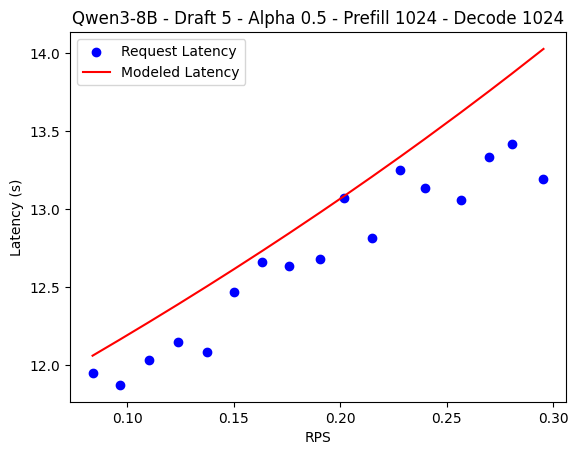

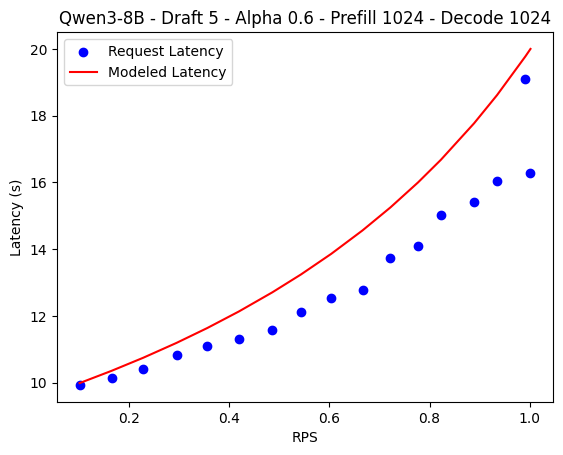

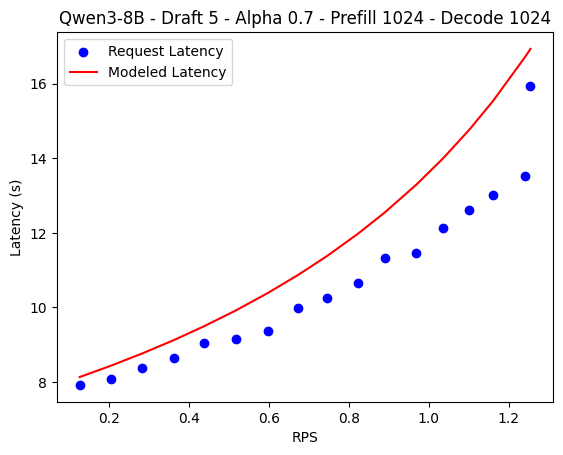

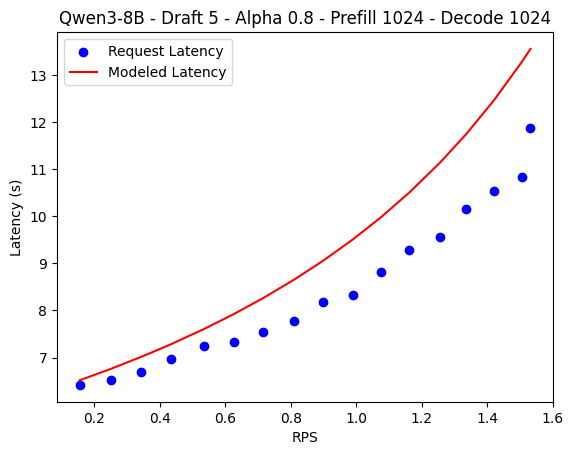

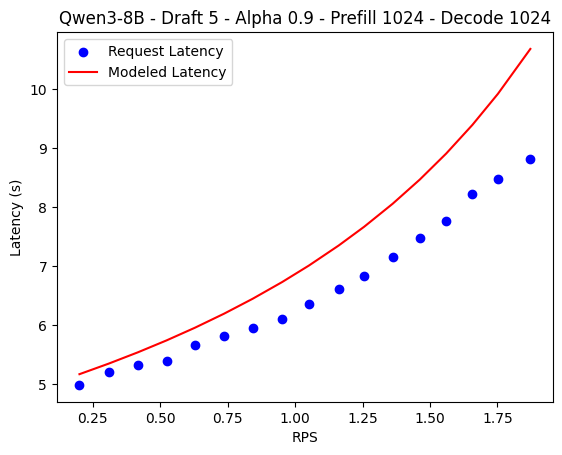

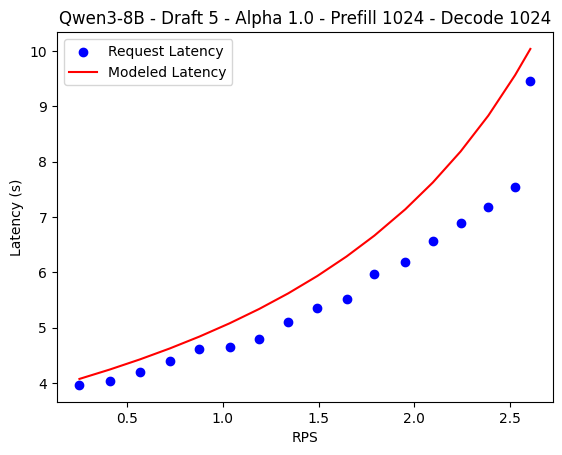

  0%|          | 0/6 [00:00<?, ?it/s]

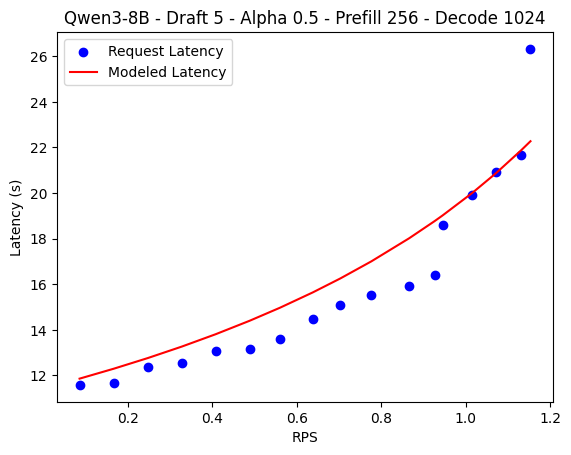

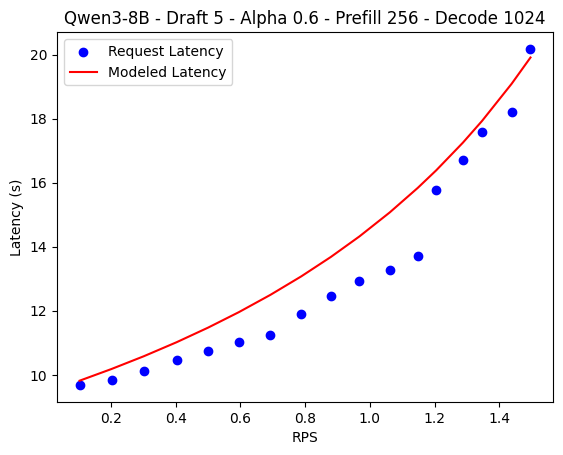

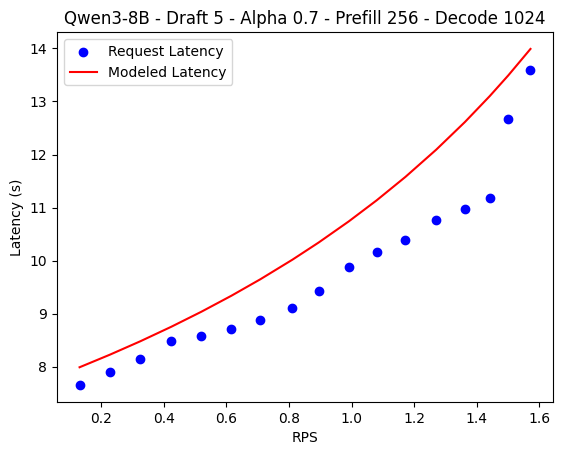

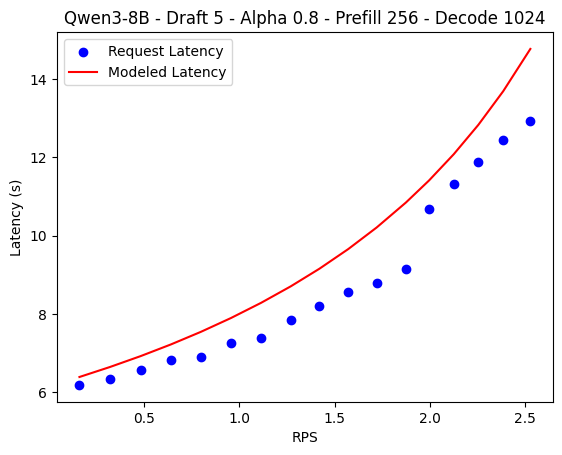

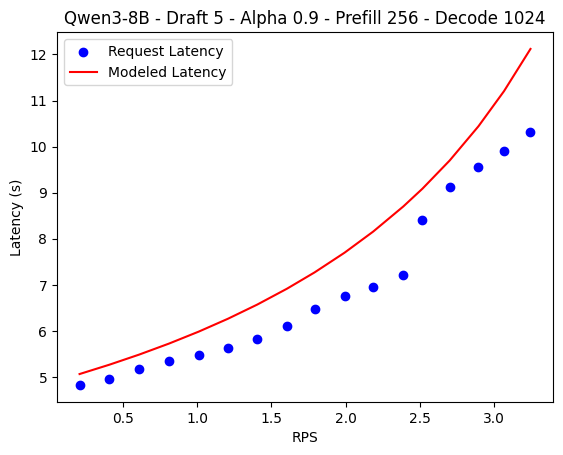

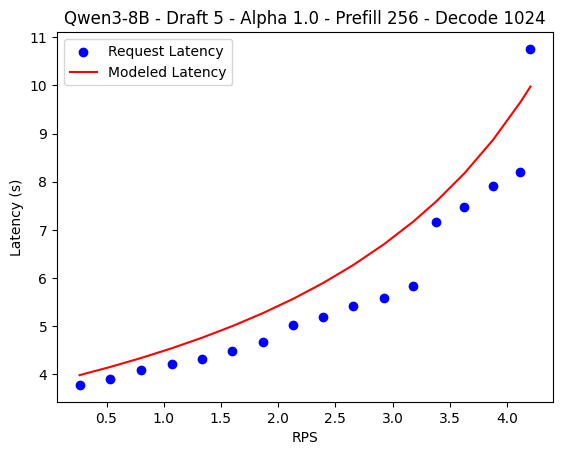

  0%|          | 0/6 [00:00<?, ?it/s]

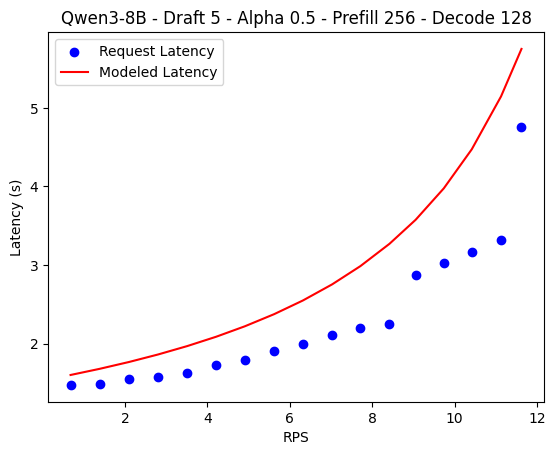

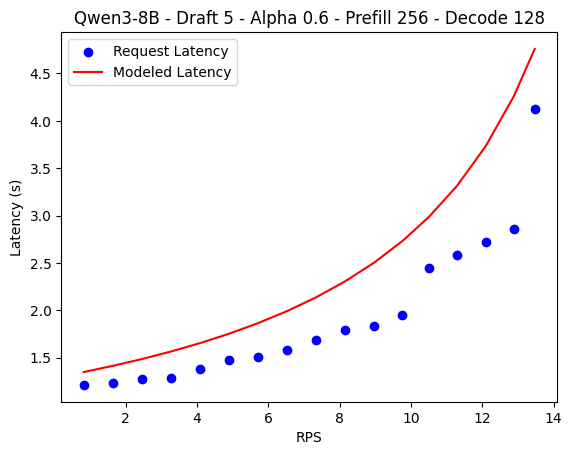

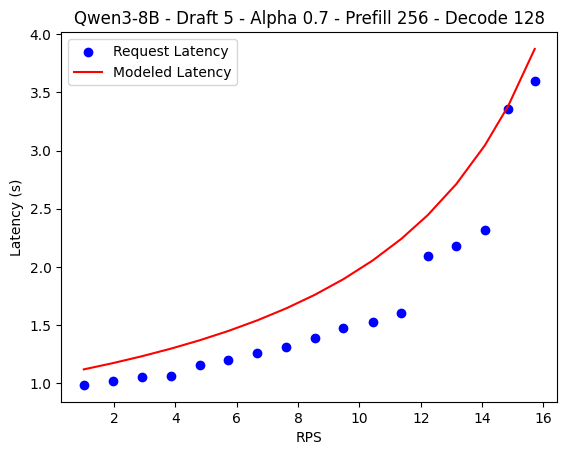

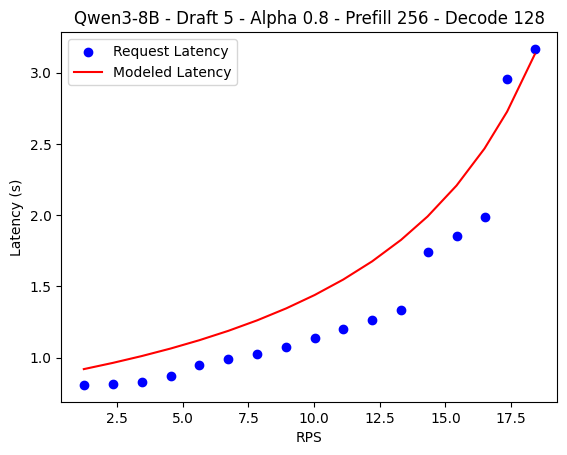

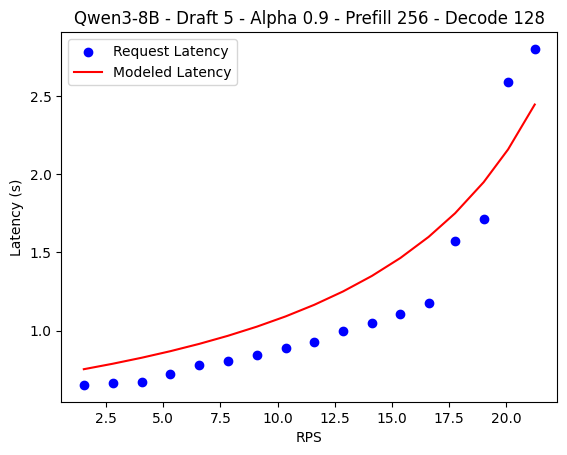

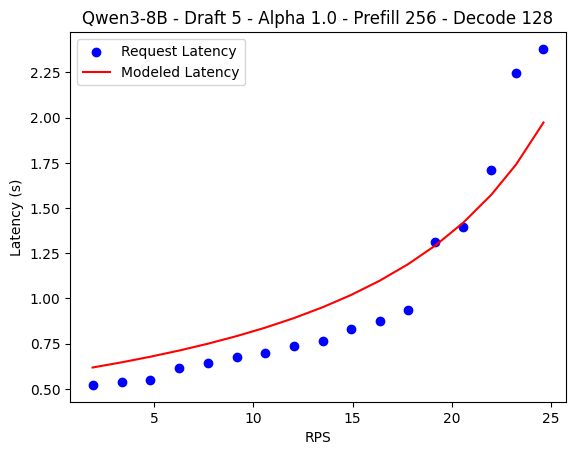

  0%|          | 0/6 [00:00<?, ?it/s]

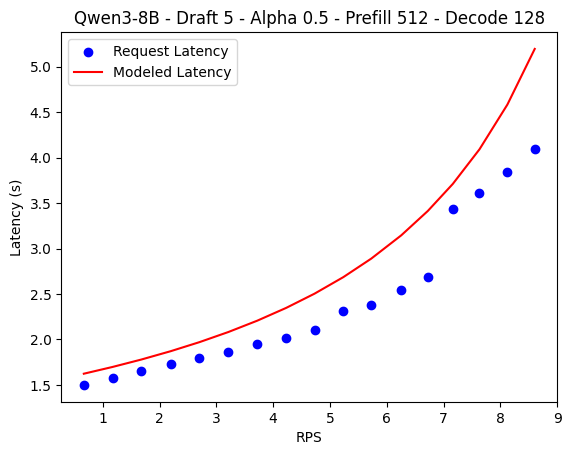

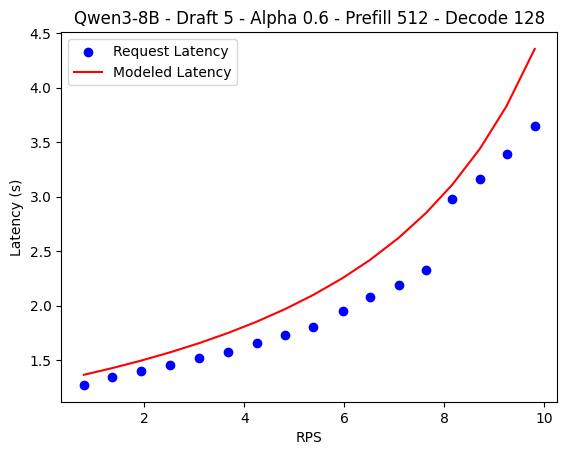

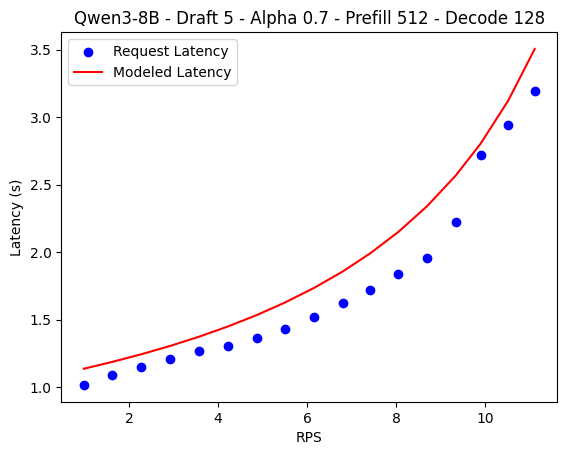

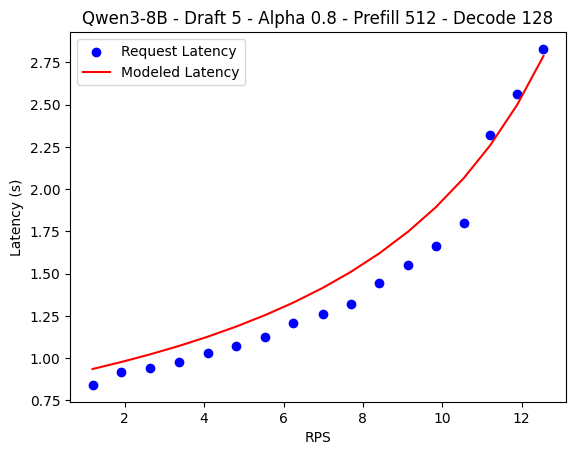

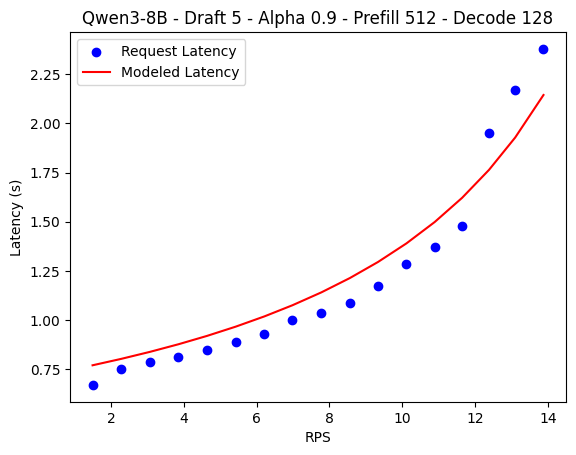

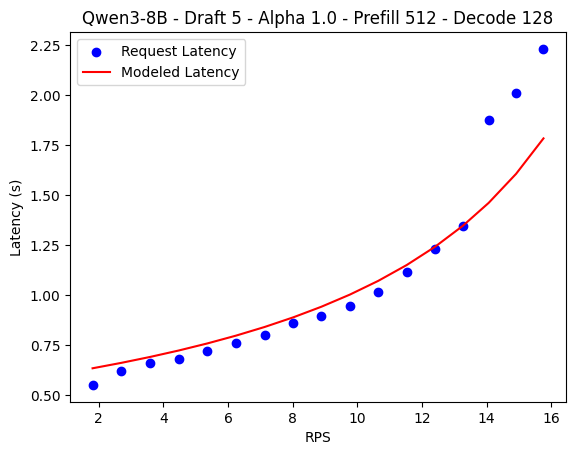

  0%|          | 0/6 [00:00<?, ?it/s]

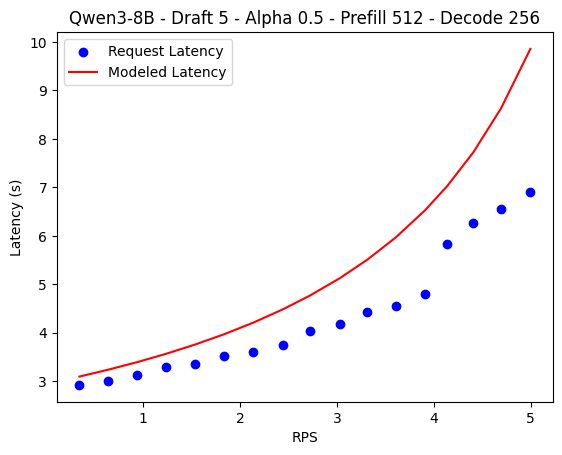

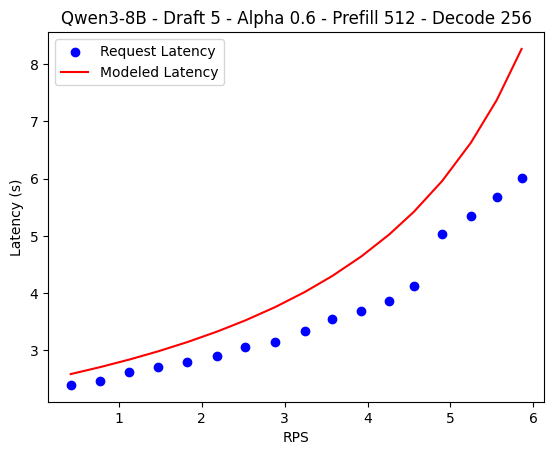

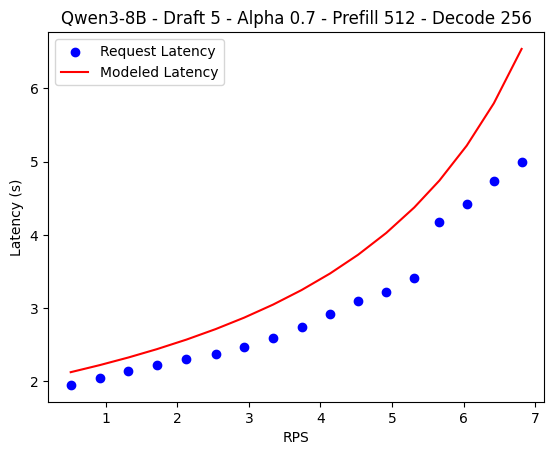

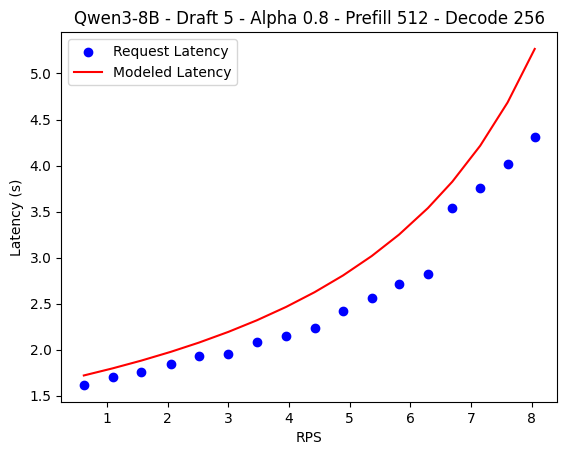

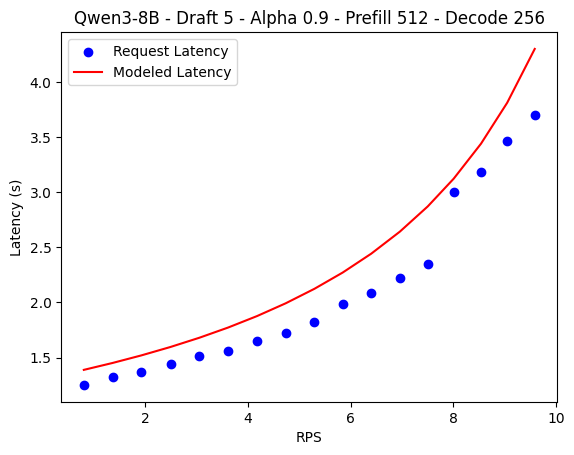

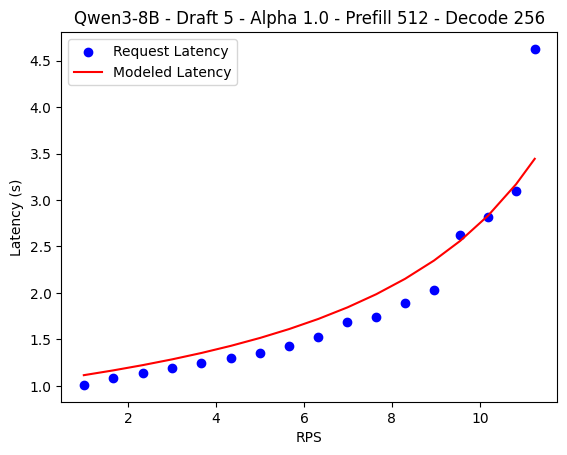

  0%|          | 0/6 [00:00<?, ?it/s]

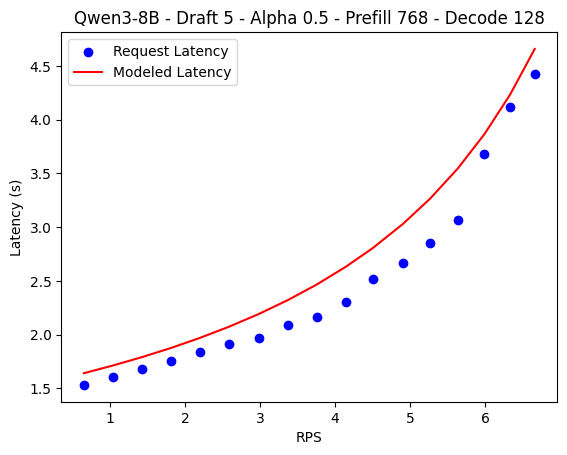

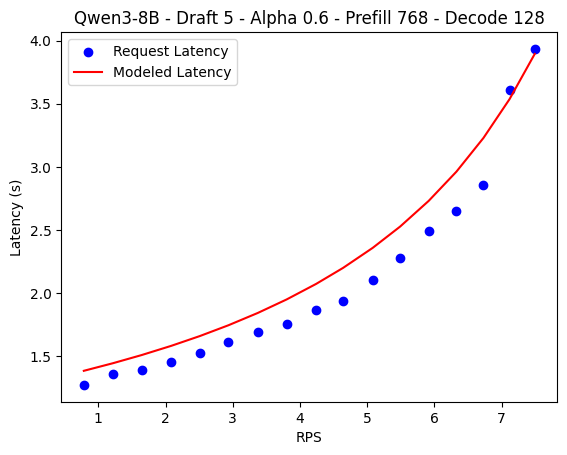

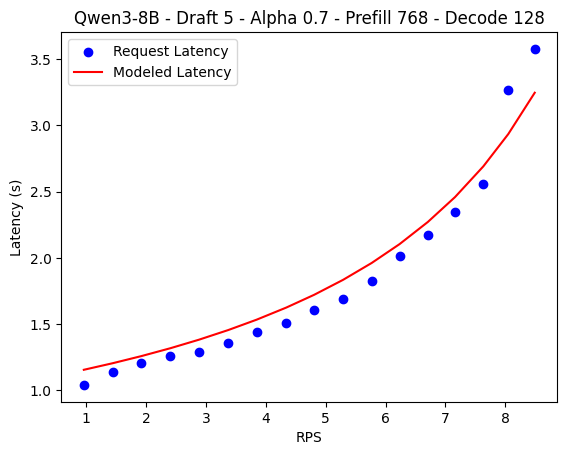

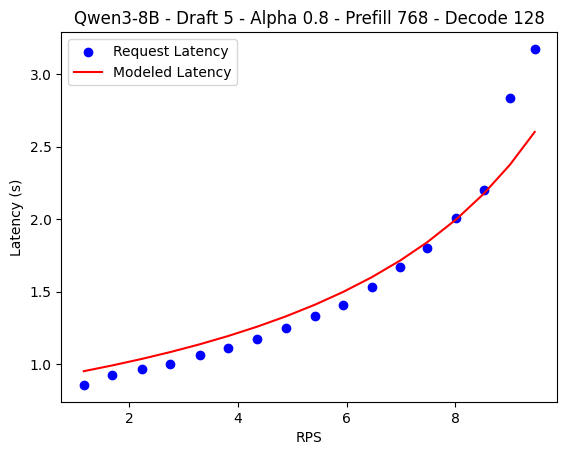

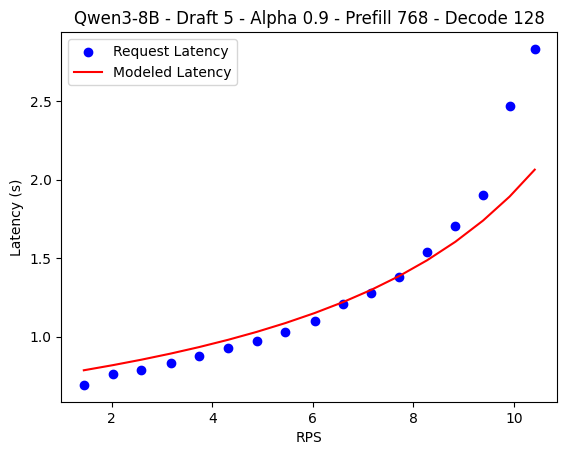

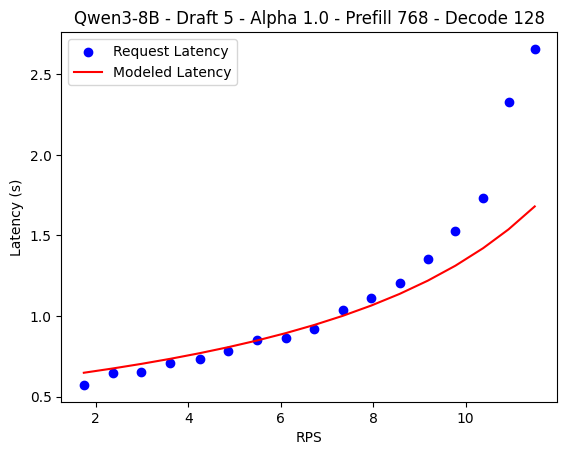

  0%|          | 0/6 [00:00<?, ?it/s]

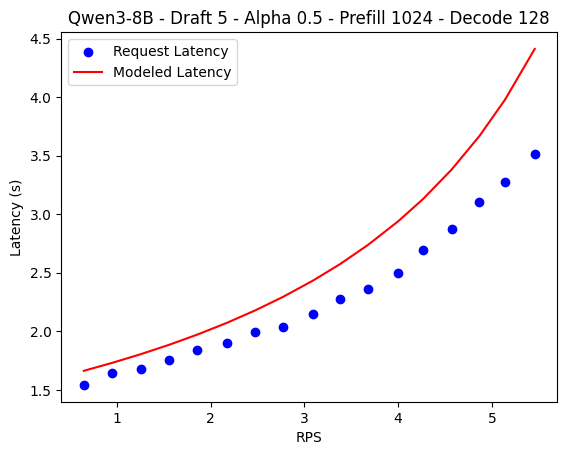

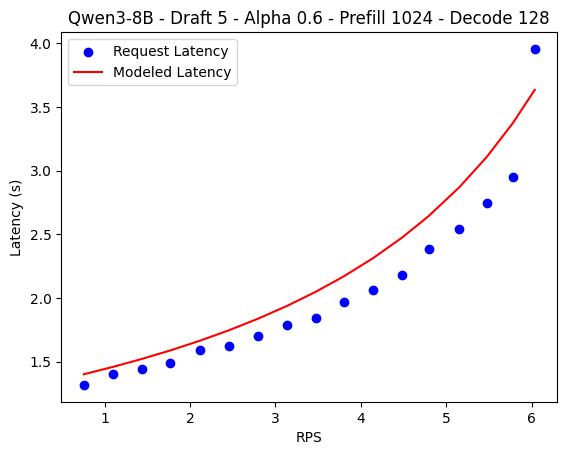

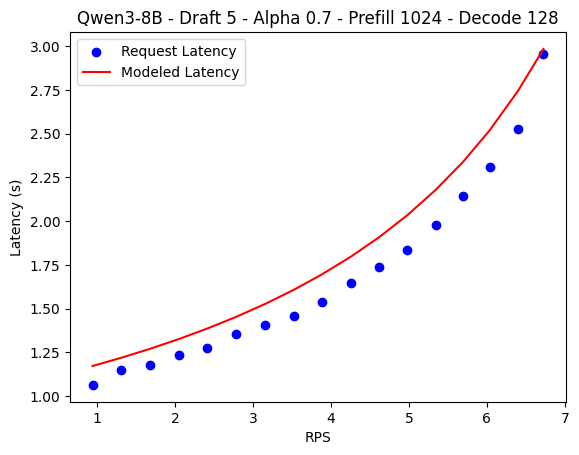

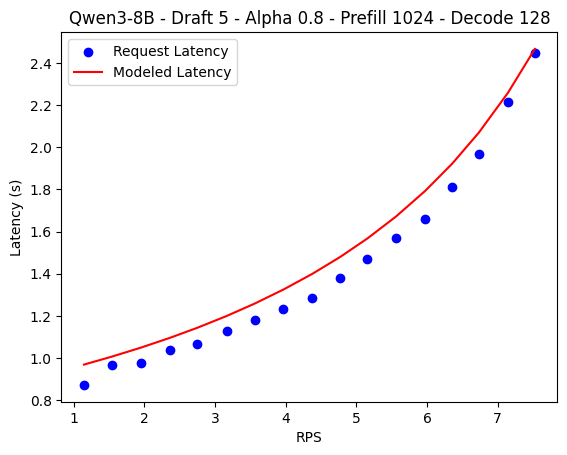

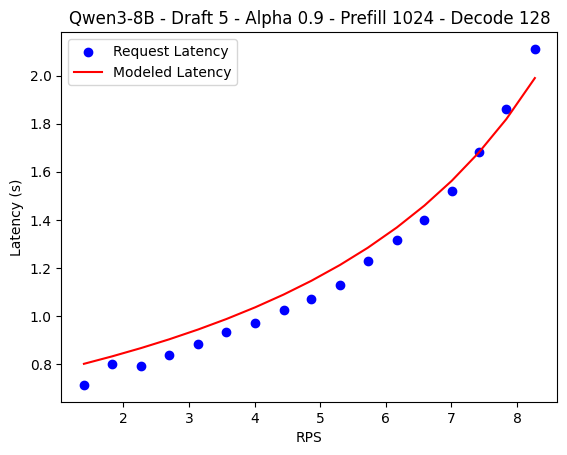

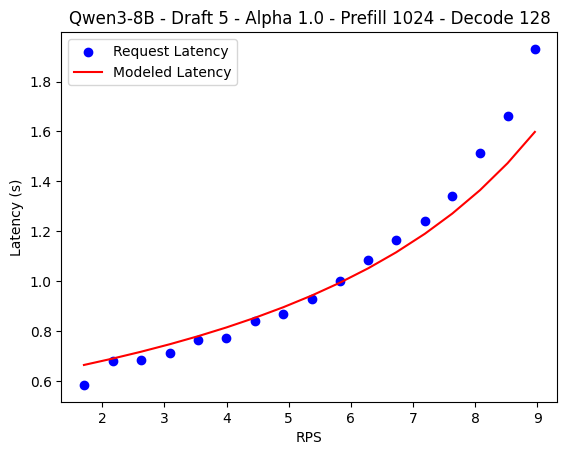

100%|██████████| 6/6 [00:00<00:00,  8.18it/s]


In [12]:
visualize_model = True

if visualize_model:
    for prefill_decode_combination in prefill_decode_combinations:
        prefill, decode = prefill_decode_combination
        for size, model_size in enumerate(tqdm(model_sizes)):
            if model_size != "8B":
                continue
            for j, draft in enumerate(drafts):
                if draft != 5:
                    continue
                for i, alpha in enumerate(alphas):
                    path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-{prefill}_output-{decode}_concurrency-128_reduced.json"
                    if not os.path.exists(path):
                        continue
                    else:
                        rps_, lat_ = getRequestLatency(path)
                        verifier_size = parameters[size]
                        drafter_size = drafter_parameters[size]
                        hidden_size = h[size]
                        number_of_layers = nlayers[size]
                        lat = pmodel.latency(draft, alpha, rps_, prefill, decode, verifier_size, drafter_size, hidden_size, number_of_layers)
                
                        plt.scatter(rps_, lat_, label='Request Latency', color='blue')
                        plt.plot(rps_, lat, label='Modeled Latency', color='red')
                        plt.title(f"Qwen3-{model_size} - Draft {draft} - Alpha {alpha} - Prefill {prefill} - Decode {decode}")
                        plt.xlabel(r"RPS")
                        plt.ylabel(r"Latency (s)")
                        plt.legend()
                        plt.show()
